In [1]:
!pip install torch_nightly -f https://download.pytorch.org/whl/nightly/cu92/torch_nightly.html
!pip install fastai

Looking in links: https://download.pytorch.org/whl/nightly/cu92/torch_nightly.html
     |████████████████████████████████| 704.8MB 26kB/s 


In [2]:
import fastai
from fastai import *
from fastai.text import * 
import pandas as pd
import numpy as np
from functools import partial
import io
import os

In [3]:
df_train = pd.read_csv('/content/drive/My Drive/Colab Notebooks/train.csv')
df_test = pd.read_csv('/content/drive/My Drive/Colab Notebooks/test.csv')
print(df_train.shape)
print(df_test.shape)

(7613, 5)
(3263, 4)


In [4]:
print(df_train.isnull().any())
print(df_test.isnull().any())



id          False
keyword      True
location     True
text        False
target      False
dtype: bool
id          False
keyword      True
location     True
text        False
dtype: bool


In [5]:
df_train = df_train.loc[:,['id','text','target']]
df_test = df_test.loc[:,['id','text']]
print(df_test)

         id                                               text
0         0                 Just happened a terrible car crash
1         2  Heard about #earthquake is different cities, s...
2         3  there is a forest fire at spot pond, geese are...
3         9           Apocalypse lighting. #Spokane #wildfires
4        11      Typhoon Soudelor kills 28 in China and Taiwan
...     ...                                                ...
3258  10861  EARTHQUAKE SAFETY LOS ANGELES ÛÒ SAFETY FASTE...
3259  10865  Storm in RI worse than last hurricane. My city...
3260  10868  Green Line derailment in Chicago http://t.co/U...
3261  10874  MEG issues Hazardous Weather Outlook (HWO) htt...
3262  10875  #CityofCalgary has activated its Municipal Eme...

[3263 rows x 2 columns]


In [6]:
X = df_train[df_train['target']==1]
y = df_train[df_train['target']==0]
print(len(X),len(y))


3271 4342


In [7]:
df_train['text'] = df_train['text'].str.replace("[^a-zA-Z]", " ")
df_test['text'] = df_test['text'].str.replace("[^a-zA-Z]"," ")


In [8]:
import nltk
nltk.download('stopwords')

from nltk.corpus import stopwords 
stop_words = stopwords.words('english')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [9]:
# tokenization 
tokenized_doc = df_train['text'].apply(lambda x: x.split())

# remove stop-words 
tokenized_doc = tokenized_doc.apply(lambda x: [item for item in x if item not in stop_words])

# de-tokenization 
detokenized_doc = [] 
for i in range(len(df_train)): 
    t = ' '.join(tokenized_doc[i]) 
    detokenized_doc.append(t) 

df_train['text'] = detokenized_doc

In [10]:
from sklearn.model_selection import train_test_split

# split data into training and validation set
df_trn, df_val = train_test_split(df_train, stratify = df_train['target'], test_size = 0.4, random_state = 12)
print(df_trn,df_val)

         id                                               text  target
6182   8823  A new favorite Midfield General Disco Sirens H...       0
4576   6506  West Nyack Pineview Road railroad crossing Wes...       1
5253   7513  Plains All American Pipeline company may spill...       1
3296   4724  Cascada Evacuate The Dancefloor Official Video...       0
2774   3990  M SETTLEMENT attained using illustrations help...       1
...     ...                                                ...     ...
7524  10760  Wreckage Conclusively Confirmed From MH Malays...       1
1038   1504                                  baskgod body bags       0
4872   6936  Not mass murderer movie theatre niggas dropped...       0
4407   6265  hot Funtenna hijacking computers send data sou...       0
3844   5469  Just added fire flames Saturday Rick Wonder sp...       0

[4567 rows x 3 columns]          id                                               text  target
7450  10662  FEVWarrior Vault could take look wounds

In [11]:
# Language model data
data_lm = TextLMDataBunch.from_df(train_df = df_trn, valid_df = df_val, path = "")

In [12]:
vocab = data_lm.vocab
print(len(vocab.itos))

4984


In [13]:
learn = language_model_learner(data_lm,  arch = AWD_LSTM, pretrained = True, drop_mult=0.7)

In [14]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


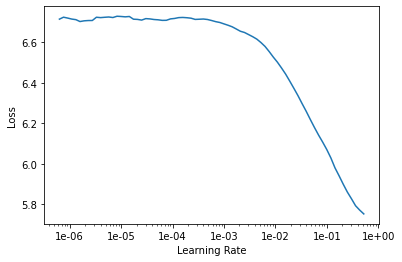

In [15]:
learn.recorder.plot(skip_end=15)

In [17]:
# train the learner object with learning rate = 1e-2
learn.fit_one_cycle(15, 1e-1)

epoch,train_loss,valid_loss,accuracy,time
0,2.695751,4.698914,0.411315,00:08
1,2.587954,4.660023,0.413977,00:07
2,2.534325,4.713526,0.414801,00:07
3,2.564188,4.785194,0.403932,00:07
4,2.608119,4.864645,0.399107,00:07
5,2.687016,4.809711,0.404155,00:07
6,2.755178,4.786796,0.409804,00:07
7,2.752060,4.787751,0.406387,00:07
8,2.751231,4.787485,0.408070,00:07
9,2.661091,4.800048,0.412946,00:07


In [18]:
print("\n".join(learn.predict('Lighting stuck the', 4, temperature=0.10) for _ in range(3)))

Lighting stuck the train derailment Village
Lighting stuck the train derailment near
Lighting stuck the train derailment near


In [23]:
print("\n".join(learn.predict('flooded all over', 4, temperature=0.10) for _ in range(3)))

flooded all over blaze xxbos The
flooded all over except idk really burning
flooded all over com xxbos The


In [24]:
learn.save_encoder('ft_enc')
